# In this notebook

[EDA](#EDA)
* Preprocessed data, train-test split
* Visualized distributions
* Generated descriptors (RDKit2D and ECFP3-count)
* Estimated upper limit of performance

[Pycaret Baseline Models](#PyCaret-Models)
* Trained baseline models with Pycaret (highest R2 on test data 0.80)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from pycaret.regression import predict_model

from solubility_model.data.make_dataset import process_data, train_test_split
from solubility_model.visualization.visualize import plot_distribution, compare_train_test_distribution, pca_then_tsne
from solubility_model.features.build_features import generate_descriptors
from solubility_model.models.pycaret_train import train_rdkit_models
from solubility_model.models.evaluate_models import regression_models

## EDA

The data was provided at the Hackathon at the AI4SD summer school 2022. The SMILES strings and Log(solubility) values were used and pre-calculated descriptors discarded. The SMILES strings were sanitized and entries with invalid SMILES were removed. The repeats were averaged using InChiKeys.

In [2]:
process_data()

[10:02:36] SMILES Parse Error: syntax error while parsing: c1ccc4c(c1)ccc5c3ccc2ccccc2c3n(H)c45
[10:02:36] SMILES Parse Error: Failed parsing SMILES 'c1ccc4c(c1)ccc5c3ccc2ccccc2c3n(H)c45' for input: 'c1ccc4c(c1)ccc5c3ccc2ccccc2c3n(H)c45'
[10:02:36] SMILES Parse Error: syntax error while parsing: c1ccc2c(CC(CC)N)cn(H)c2c1
[10:02:36] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(CC(CC)N)cn(H)c2c1' for input: 'c1ccc2c(CC(CC)N)cn(H)c2c1'
[10:02:36] SMILES Parse Error: syntax error while parsing: N#CC(c2ccccc2)OC3(C(C(O)(H)C(C(O3)(COC1(C(C(O)(H)C(C(O1)(CO)H)(O)H)(O)H)H)H)(O)H)(O)H)H
[10:02:36] SMILES Parse Error: Failed parsing SMILES 'N#CC(c2ccccc2)OC3(C(C(O)(H)C(C(O3)(COC1(C(C(O)(H)C(C(O1)(CO)H)(O)H)(O)H)H)H)(O)H)(O)H)H' for input: 'N#CC(c2ccccc2)OC3(C(C(O)(H)C(C(O3)(COC1(C(C(O)(H)C(C(O1)(CO)H)(O)H)(O)H)H)H)(O)H)(O)H)H'
[10:02:36] SMILES Parse Error: syntax error while parsing: O=C(O)CC(c(c(N1(H))ccc2)c2)=C1
[10:02:36] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CC(c(c(N1(H))ccc

A quick look at the distribution of the data. The data is roughly normally distributued, with a range from -12 to 1. 

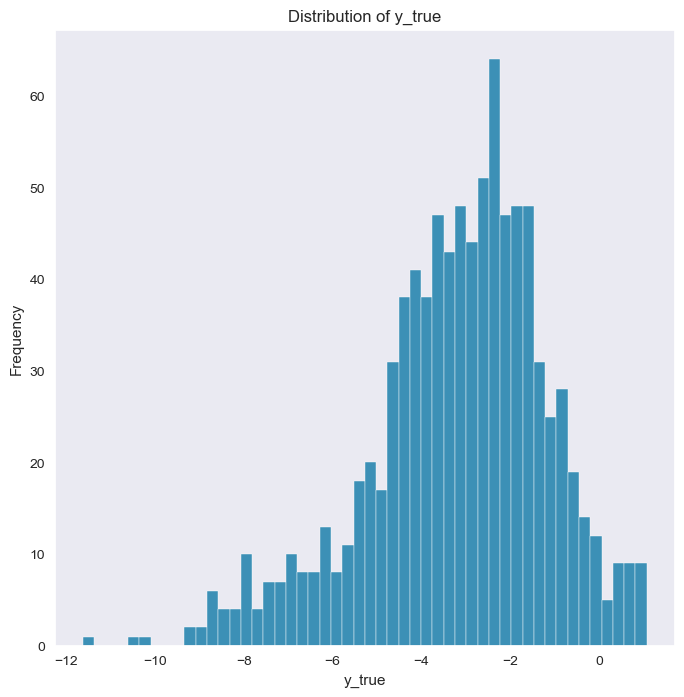

In [3]:
internal_data = pd.read_csv("../data/interim/processed_dataset.csv")
plot_distribution(internal_data, "y_true")

The data was split into training and test sets using a scaffold-split with a test fraction of 0.2. A scaffold split is used to stop the model overfitting to scaffolds in the training set. Descriptors were generated (all RDKit 2D descriptors and an extended connectivity fingerprint count - radius 3) for all compounds. The distributions of the training and test sets are broadly similar.

(516, 2262) (516, 2) (395, 2262) (395, 2)


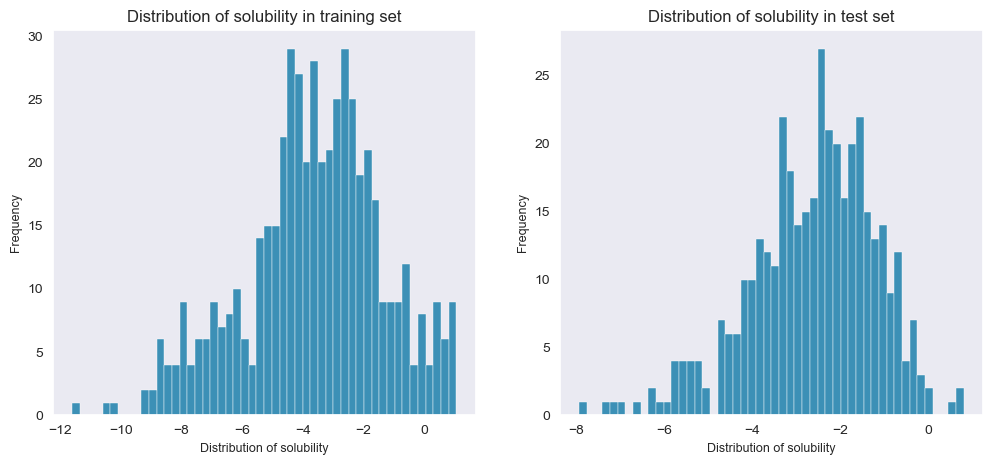

In [4]:
# Train test split
train_test_split(how="scaffold")

# Generate features
generate_descriptors()

# Check dimensions and for Nan
X_train = pd.read_csv("../data/processed/train_descriptors.csv")
y_train = pd.read_csv("../data/processed/train_smiles.csv")
X_test = pd.read_csv("../data/processed/test_descriptors.csv")
y_test = pd.read_csv("../data/processed/test_smiles.csv")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Visualize distributions of training and set datasets
compare_train_test_distribution(train=y_train, test=y_test, column="y_true", name="solubility")

PCA was used for dimensionality reduction of the RDKit 2D descriptors to give 50 principle components. These were then further reduced using tSNE to give two dimensions, which were plotted with the training and test data points labelled. Both sets cover similar chemical space with some clusters of test data in the gaps in the train data. One cluster of test compounds is seen at the top of the tSNE plot outside the chemical space of most of the training set.

Variance in top 50 principle components: 0.887


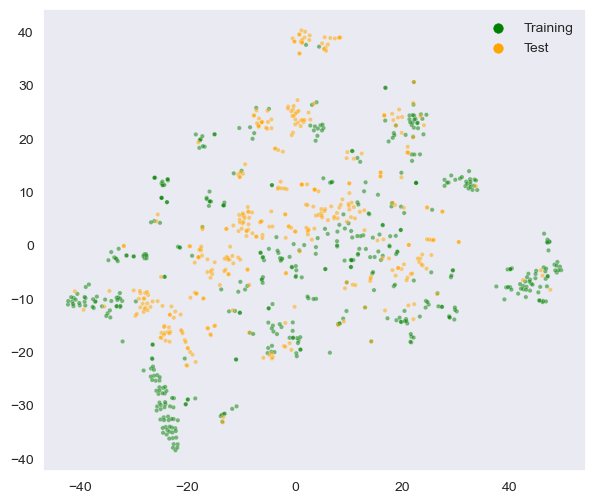

In [5]:
pca_then_tsne(
    features = [X_train.iloc[:,-214:], X_test.iloc[:,-214:]],
    classes = ["Training", "Test"]
    )

The upper limit of a models performance due to aleatoric uncertainty (inherent uncertainty in the data) was estimated. Errors in measured Log S  were suggested from 0.5 - 2. For each estimate, the error was used to add random noise to 10,000 bootstrapped samples from the training data based on a normal distribution of noise. These simulated data points were plotted against the true value and an R2 value calulated. With Log S error stdev of 0.5 log units, an R2 of 0.95 is possible, but this drops as the error increases.

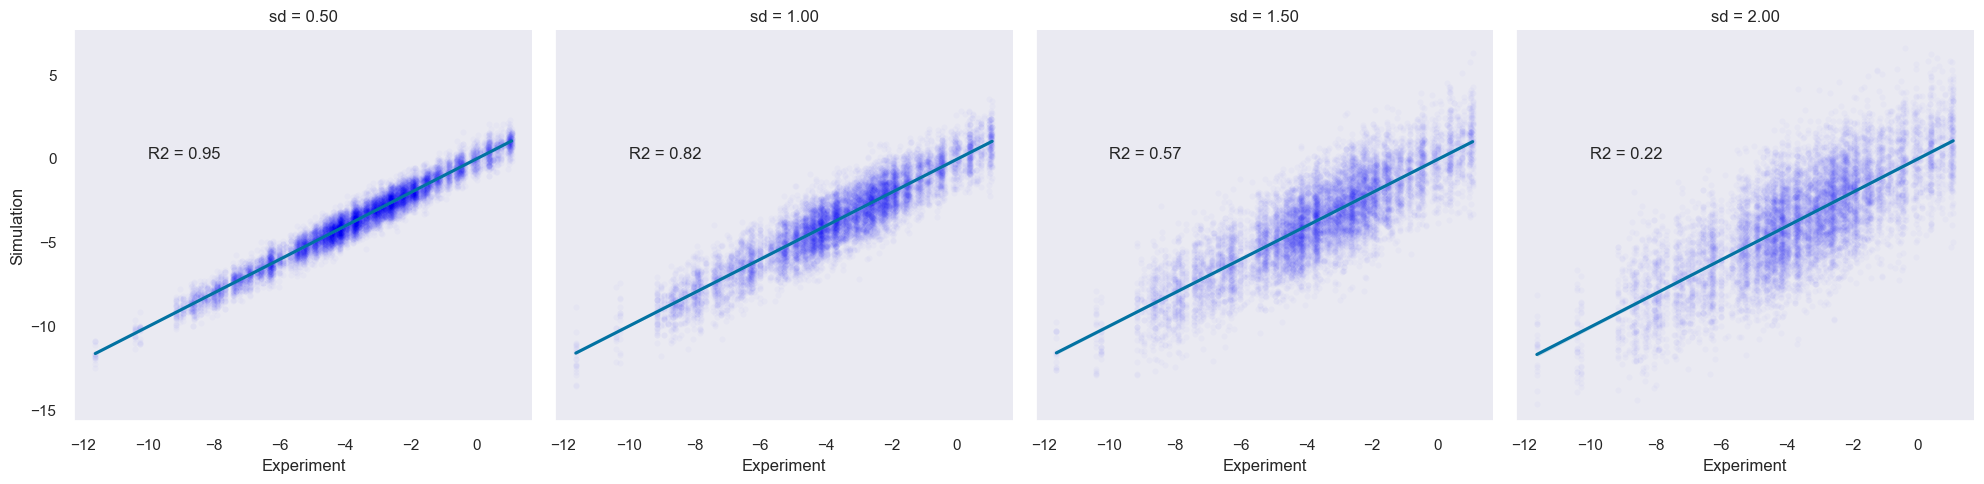

In [6]:
errors = [0.5, 1, 1.5, 2]

train_data = pd.read_csv('../data/processed/train_smiles.csv')
val_list = []
for i in errors:
    for j in range(0,10000):
        val = np.random.choice(train_data.y_true)
        err = np.random.normal(0,i)
        val_list.append([f"{i:.2f}",val,val+err])
val_df = pd.DataFrame(val_list,columns=["sd","val","err"])

labels = {}
for k,v in val_df.groupby("sd"):
    R2 = r2_score(v.val,v.err)
    label = f"R2 = {R2:.02f}"
    labels[float(k)] = label
label_list = [labels[x] for x in sorted(list(labels.keys()))]
    
sns.set_context('notebook')
g = sns.lmplot(x="val",y="err",col="sd",data=val_df, height=5,
           scatter_kws=dict(alpha=0.02, s=20, color='blue', edgecolors='white'))
g.set_xlabels("Experiment")
g.set_ylabels("Simulation")
for ax,label in zip(g.axes[0],label_list):
    ax.text(-10, 0, label)

### PyCaret Models

Pycaret is an AutoML package that was used to train 25 classical ML models on the training data using a scaffold split to create a validation set. The top 4 models were selected and had their hyperparameters tuned. The models were finalized using these hyperparameters and all the training data. The four trained models were used to make predictions on the training data then the test data and the performance of these predictions were evaluated and plotted. All models perform well on the training data (R2 0.97-1.00) but due to overfitting do not perform as well on the test data (R2 0.69-0.80) with the ExtraTreesRegressor performing best.

In [7]:
# PyCaret baseline models
pycaret_models = train_rdkit_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2791,0.1330,0.3646,0.9747,0.1147,0.3042


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2633,0.1104,0.3323,0.9790,0.1049,0.3003


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1939,0.0667,0.2582,0.9873,0.0841,0.2468


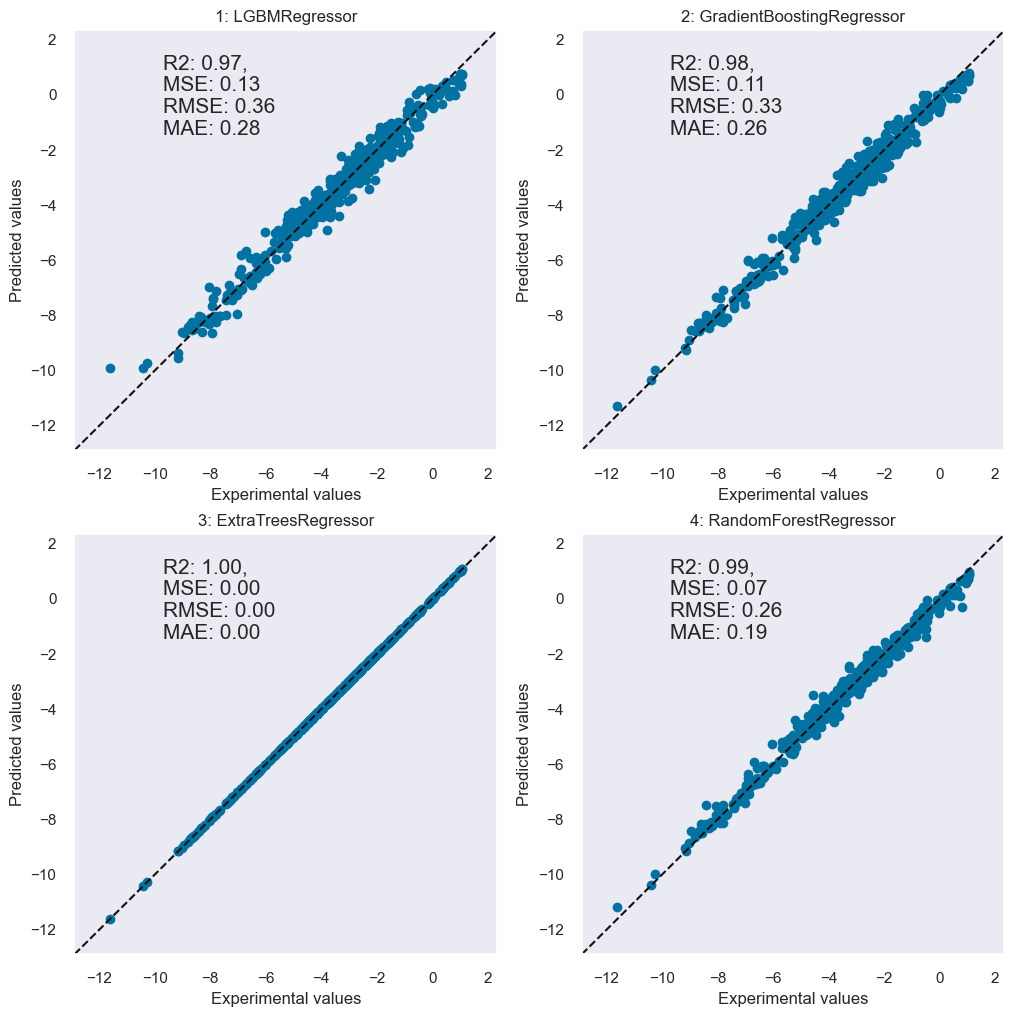

In [8]:
train_desc = pd.read_csv('../data/processed/train_descriptors.csv')
train_data = pd.read_csv('../data/processed/train_smiles.csv')

regression_models(train_desc, train_data.y_true, pycaret_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6075,0.5594,0.7479,0.7255,0.2636,0.3594


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.5345,0.4542,0.6739,0.7771,0.2315,0.3222


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5108,0.4088,0.6394,0.7994,0.2121,0.3268


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6508,0.6385,0.7991,0.6866,0.2730,0.3732


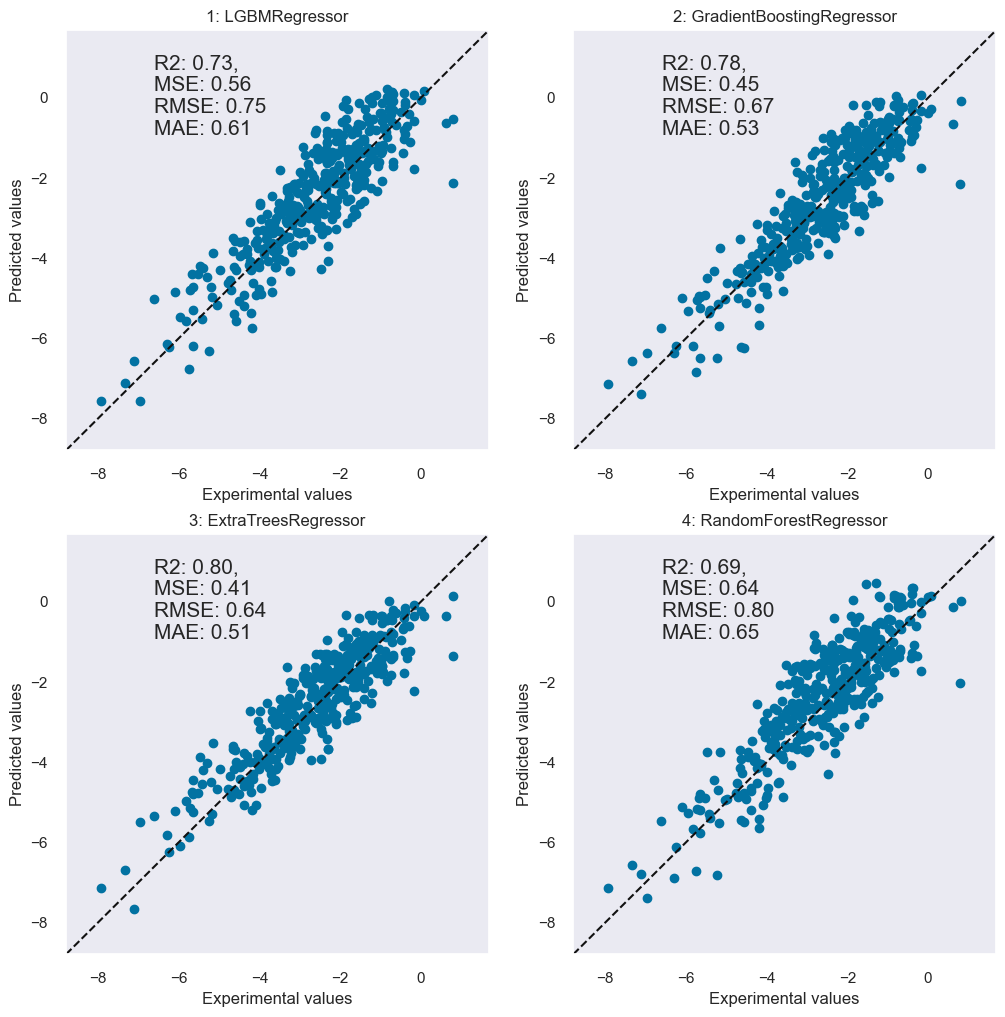

In [9]:
test_desc = pd.read_csv('../data/processed/test_descriptors.csv')
test_data = pd.read_csv('../data/processed/test_smiles.csv')

regression_models(test_desc, test_data.y_true, pycaret_models)

A plot of the predictions with the 10% worst highlighted has most of the worst predictions fairly evenly distributed.

Variance in top 50 principle components: 0.887


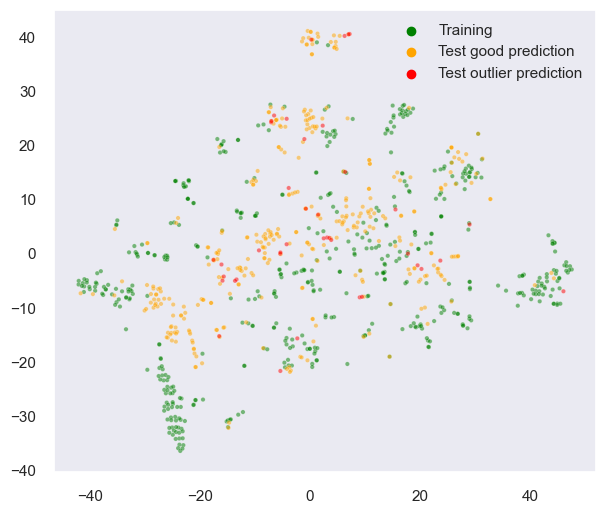

In [16]:
preds_df = pd.concat([test_data, predict_model(pycaret_models[0], data=test_desc).prediction_label], axis=1)
preds_df['residuals'] = abs(preds_df.y_true - preds_df.prediction_label)
worst_10_cutoff = preds_df.residuals.quantile(0.9)
preds_df['outlier'] = np.where(preds_df.residuals > worst_10_cutoff, 1, 0)

pca_then_tsne(
    features = [train_desc.iloc[:,-214:],
                test_desc.iloc[:,-214:][preds_df.outlier == 0],
                test_desc.iloc[:,-214:][preds_df.outlier == 1]
                ],
    classes = ["Training", "Test good prediction", "Test outlier prediction"]
    )